# Installation
The purpose of this notebook is to give a working example of the library and how to use it. First, we begin by installing the library. Note that it takes some time to install the library because of the dependencies, be patient!

In [1]:
%pip install git+https://github.com/JadM133/RRAEs.git

Note: you may need to restart the kernel to use updated packages.Collecting git+https://github.com/JadM133/RRAEs.git
  Cloning https://github.com/JadM133/RRAEs.git to c:\users\jadmo\appdata\local\temp\pip-req-build-g7xcp0b4
  Resolved https://github.com/JadM133/RRAEs.git to commit 0eec9e56f4180d69aa45bef5e29aec0f55833ea8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'



  Running command git clone --filter=blob:none --quiet https://github.com/JadM133/RRAEs.git 'C:\Users\jadmo\AppData\Local\Temp\pip-req-build-g7xcp0b4'

[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Now that the library is installed, you can acces the library with the name ``RRAEs``. We begin by creating a simple training data, the library presents a function within ``utilities`` named ``get_data`` that generates the data used in the paper and many more. In this case, we will use the shifted sine functions as a simple example.

Train shape: (200, 17), or (200, 17)
Test shape: (200, 80), or (200, 80)
Train parameters shape: (17, 1)
Test parameters shape: (80, 1)


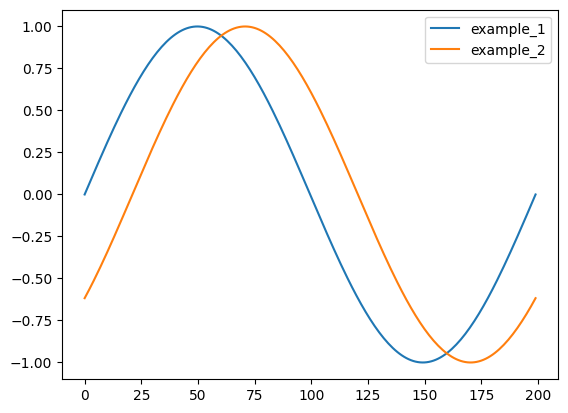

In [10]:
from RRAEs.utilities import get_data
import matplotlib.pyplot as plt
ts, x_train, x_test, p_train, p_test, _, _, _, y_train, y_test, args = get_data("shift")
# In general, you won't use get_data, you will have your own data with the same shapes.
print(f"Train shape: {x_train.shape}, or {y_train.shape}")
print(f"Test shape: {x_test.shape}, or {y_test.shape}")
print(f"Train parameters shape: {p_train.shape}")
print(f"Test parameters shape: {p_test.shape}")
plt.plot(x_train[:, 0], label="example_1")
plt.plot(x_train[:, 2], label="example_2")
plt.legend()

In this case, ``x_train`` and ``y_train`` are the same matrices, since we want the autoencoder to have as an output the same thing as the input. Similarly, ``x_test`` and ``y_test`` are the same. We can also see that we only have one parameter (the last dimension of ``p_train`` and ``p_test``), which is expected for the problem of the shifted sines (shifted by one parameter). In general, when generating your own data, x and y should have the shape (T x N) and the parameters should have a shape of (N x P), N being the number of samples (wether for train or test), T being the time discretisation dimension, and P being the dimension of the parametric space.

Next, we creat the model,

In [11]:
from RRAEs import Strong_RRAE_MLP, Weak_RRAE_MLP
import jax.random as jrandom
latent_size = 500
k_max = 1
kwargs_enc={"width_size":64, "depth":1}
kwargs_dec={"width_size":64, "depth":5}
model_key = jrandom.PRNGKey(0) # JAX needs key for generating random values, this is a necessary keword argument in the classes.

model_Strong = Strong_RRAE_MLP(x_train, latent_size, k_max, key=model_key, kwargs_enc=kwargs_enc, kwargs_dec=kwargs_dec)
model_Weak = Weak_RRAE_MLP(x_train, latent_size, k_max, key=model_key, kwargs_enc=kwargs_enc, kwargs_dec=kwargs_dec)

# You can give any kwargs needed for the encoder in kwargs_enc, and for the decoder in kwargs_dec. If nothing is given,
# the encoder will have a depth of 1 and a width of 64, and the decoder will have a depth of 6 and a width of 64.

Let's test the models now by aplying them to our training data.

In [12]:
print(f"x_train shape before: {x_train.shape}")
print(f" Shape after Strong: {model_Strong(x_train).shape}")
print(f" Shape after Weak: {model_Weak(x_train).shape}")

x_train shape before: (200, 17)
 Shape after Strong: (200, 17)
 Shape after Weak: (200, 17)


We expect all shapes to be the same since we want to predict the original values as output, great!

The Strong formulation performs a truncates SVD after the latent space, while the weak one for now is just a Vanilla Autoencoder, the difference will come in the loss later on.

Now, let's train the model on our data. The library provides a trainor class that does the training for you, if you know how to use it :) 

We define the trainor class for each of the Weak/Strong formulation as follows (In practice, you only need one of these).

In [13]:
from RRAEs import Objects_Interpolator_nD, Trainor_class

interpolation_cls = Objects_Interpolator_nD # Interpolation class for test, only this one available for now
model_cls = Strong_RRAE_MLP # Without parenthesis! Only the class

trainor_Strong = Trainor_class(
            model_cls,
            interpolation_cls,
            data=x_train,
            latent_size=latent_size,  # 4600
            k_max=k_max,
            folder=f"test/",
            file=f"testing_strong",
            key=jrandom.PRNGKey(0),
        )

model_cls = Weak_RRAE_MLP # Without parenthesis! Only the class
trainor_Weak = Trainor_class(
            model_cls,
            interpolation_cls,
            data=x_train,
            latent_size=latent_size,  # 4600
            k_max=k_max,
            folder=f"test/",
            file=f"testing_Weak",
            key=jrandom.PRNGKey(100),
        )

Now, we can use the ``fit`` method of the trainor class, and give it any training arguments as follows,

In [14]:
training_kwargs = {
            "step_st": [1500, 1500, 1500], # number of batches strategy
            "batch_size_st": [20, 20, 20, 20], # batch size strategy
            "lr_st": [1e-3, 1e-4, 1e-5], # learning rate strategy
            "print_every": 100,
        }

_ = trainor_Strong.fit(
    x_train,
    y_train,
    loss_func="Strong",
    training_key=jrandom.PRNGKey(50),
    **training_kwargs,
)

Training the RRAE...
Step: 0, Loss: 116.45399475097656, Computation time: 0.7258141040802002
Step: 100, Loss: 47.166969299316406, Computation time: 0.3049285411834717
Step: 200, Loss: 28.38720703125, Computation time: 0.1892712116241455
Step: 300, Loss: 27.899574279785156, Computation time: 0.1910538673400879
Step: 400, Loss: 23.150236129760742, Computation time: 0.18372797966003418
Step: 500, Loss: 22.578964233398438, Computation time: 0.189985990524292
Step: 600, Loss: 27.0695858001709, Computation time: 0.19587063789367676
Step: 700, Loss: 20.151386260986328, Computation time: 0.1879737377166748
Step: 800, Loss: 20.61111068725586, Computation time: 0.18856239318847656
Step: 900, Loss: 18.63743019104004, Computation time: 0.18613457679748535
Step: 1000, Loss: 19.068172454833984, Computation time: 0.18700337409973145
Step: 1100, Loss: 21.988853454589844, Computation time: 0.16710829734802246
Step: 1200, Loss: 22.35871124267578, Computation time: 0.16876864433288574
Step: 1300, Loss: 1

We trained RRAEs with the Strong formulation!!! Training using the Weak formulation is Similar, by replacing ``loss_func`` by ``Weak`` the loss automatically includes matrices ``U`` and ``A`` in the loss (check the paper for more details). The only difference is that we might multiply the learning rate before modifying the gradient of ``A`` (check Appendix B in the paper for why and how this helps, instead of modifying the loss constants). This is done as follows,

In [15]:
training_kwargs = {
            "step_st": [1500, 1500, 1500], # number of batches strategy
            "batch_size_st": [20, 20, 20, 20], # batch size strategy
            "lr_st": [1e-3, 1e-4, 1e-5], # learning rate strategy
            "print_every": 100,
            "mul_lr":[0.05, 0.05, 0.05], # The values of kappa (to multiply lr for A)
            "mul_lr_func": lambda tree: (tree.v_vt.vt,), # Who will be affected by kappa, this means A
        }

_ = trainor_Weak.fit(
    x_train,
    y_train,
    loss_func="Weak",
    training_key=jrandom.PRNGKey(50),
    **training_kwargs,
)

Training the RRAE...
Step: 0, Loss: 221.92001342773438, Computation time: 0.7933542728424072, loss1: 121.90615844726562, loss2: 100.01386260986328
Step: 100, Loss: 159.1533966064453, Computation time: 0.2965366840362549, loss1: 68.10096740722656, loss2: 91.05242156982422
Step: 200, Loss: 150.6331787109375, Computation time: 0.294980525970459, loss1: 66.68775939941406, loss2: 83.9454345703125
Step: 300, Loss: 142.35281372070312, Computation time: 0.32119250297546387, loss1: 66.69721221923828, loss2: 75.65559387207031
Step: 400, Loss: 134.81057739257812, Computation time: 0.29891324043273926, loss1: 69.56236267089844, loss2: 65.24822235107422
Step: 500, Loss: 124.28629302978516, Computation time: 0.31699419021606445, loss1: 67.96214294433594, loss2: 56.32415008544922
Step: 600, Loss: 111.99493408203125, Computation time: 0.40094995498657227, loss1: 66.42060852050781, loss2: 45.57432174682617
Step: 700, Loss: 101.90022277832031, Computation time: 0.31254029273986816, loss1: 61.03066635131

As you can see, choosing the Weak option for the loss function will automatically print loss1 and loss2, the first being how far our prediction of the input is, and loss2 give us an idea of how low the rank is. If loss2 is decreasing too fast, you should decrease the value of kappa, otherwise, you must increase it.

Now, after training, we assign most of the important results inside the trainor class (i.e. ``trainor_Strong`` or ``trainor_Weak``). Next, we show how to interpolate in the latent space for the test set. The trainor class offers a function ``post_process`` that does that automatically as follows.

In [16]:
error_train_str, error_test_str, _, _ = trainor_Strong.post_process(y_test, None, None, p_train, p_test, interp=True)
error_train_we, error_test_we, _, _ = trainor_Weak.post_process(y_test, None, None, p_train, p_test, interp=True)

Train error:  3.2777429
Test error:  4.399102
Total computation time:  8.971785545349121
Train error:  10.549414
Test error:  10.855703
Total computation time:  13.97601842880249


Now, all the important variables are saved inside the trainor class, you can access some stuff as follows,

In [18]:
trainor_Strong.model # the model trained
trainor_Strong.y_pred_test # predictions over test
trainor_Strong.y_pred_train # predictions over train
trainor_Strong.vt_train # latent coefficients for the train set
trainor_Strong.vt_train # interpolated latent coefficients
trainor_Strong.p_train # parameters for train set

Array([[0.        ],
       [0.10588235],
       [0.21176471],
       [0.31764707],
       [0.42352942],
       [0.5294118 ],
       [0.63529414],
       [0.7411765 ],
       [0.84705883],
       [0.9529412 ],
       [1.0588236 ],
       [1.1647059 ],
       [1.2705883 ],
       [1.3764706 ],
       [1.482353  ],
       [1.5882353 ],
       [1.6941177 ]], dtype=float32)

And many more! For example, let's plot some predictions over the test set to compare between the Weak and Strong formulation.

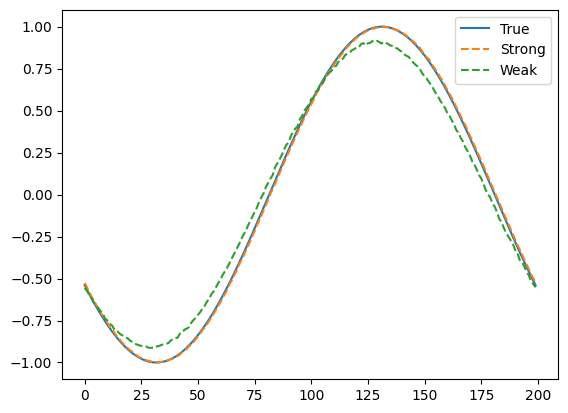

In [20]:
plt.plot(y_test[:, 10], label="True")
plt.plot(trainor_Strong.y_pred_test[:, 10], label="Strong", linestyle="--")
plt.plot(trainor_Weak.y_pred_test[:, 10], label="Weak", linestyle="--")
plt.legend()

Now definitely, the Weak method can do as well as the Strong one for the right value of kappa, you just need some fine tuning.

Finally, you can save the model by using the built-in ``save`` function of the trainor class, it will save the model in the foler and file that you specified previously when defining the trainor class as follows.

In [ ]:
trainor_Strong.save()
trainor_Weak.save()

Later on, if you want to load the trainor again, you define a trainor class with no attributes and load the class as follows

In [ ]:
import os
folder = f"test/"
file = f"testing_strong"
new_trainor = Trainor_class()
new_trainor.load(os.path.join(folder, file))